# Data Mining Project - NBA player Classification based on role
### Federico Russo

## Introduction

In this work, my aim is to test and demonstrate the effectiveness of Data Mining and Machine Learning techniques applied in the field of sports, focusing on player performances.

I chose American basketball due to the vast amount of data available for each player. Specifically, the NBA, the most famous professional league, collects a plethora of statistics, ranging from simple to complex, for every athlete. These data are increasingly crucial for developing gameplay strategies, improving team schemes and tactics, identifying young prospects, and potential future stars. The online betting sector also greatly benefits from studying these statistics, as analyzing recurring patterns allows for predicting team and individual player performances based on historical data.

In the NBA, players are divided into five roles: Point Guard, Shooting Guard, Power Forward, Small Forward, and Center. In this study, I aimed to create a classification model capable of distinguishing player performance statistics across these various roles.

From a theoretical standpoint, this model demonstrates the effectiveness of Data Mining and Machine Learning techniques applied to the basketball world. From a tactical perspective, it can aid in developing a more cohesive game by identifying the distinctive characteristics of each role, thus allowing each player to assume the position most suited to their abilities.

To accomplish this, the work was conducted following these steps:

   - Creation of the dataset through web scraping operations;
   - Data Cleaning and Preprocessing operations;
   - Analysis of the cleaned dataset;
   - Selection of the most performing classification model;
   - Hyperparameters tuning for the chosen model.
    
## Dataset Creation

The dataset was constructed by extracting data from two main sources:

   - The official NBA website, primarily used to extract advanced statistics related to player possessions.
   - The basketball-reference website, from which all information regarding team rosters, seasonal statistical averages for both basic and advanced player statistics, and individual game stat lines for each player were obtained.

All extracted data were stored in a SQLite database in different tables for easy future use.

To retrieve data from the websites, I employed web scraping techniques while adhering to the constraints set by the administrators of the respective domains.

Specifically for the website www.basketball-reference.com, I utilized a library available on GitHub (https://github.com/vishaalagartha/basketball_reference_scraper/blob/master/API.md) that provides an API for correctly receiving data in the desired format. I used a Python script to gather data on:

   - Team rosters from 2008 to 2024: a table containing the names of all players per team along with their biographical information and their role within the team.
   - Player statistical averages from 2008 to 2024: data comprising various tables depending on the type of statistics. I collected per-game averages, per-36-minute statistics, and advanced statistics for all regular season (82 games) and playoff games (which were not utilized).
   - Statistics collected from each player for individual games in the 2024 season: a very extensive table containing an entry for each game of the regular season played by a player.

For the NBA website www.nba.com, I developed a Python script capable of retrieving data from the tables available on the site by sending a sequence of requests. In this case, the retrieved data only pertained to a specific category of advanced statistics: player possessions statistics (number of dribbles, time of ball possession, etc.). However, these data are only available for seasonal averages and for the seasons from 2014 to 2024. These data were also collected in a table in the database.

The code used to obtain the data and the complete database are available on the following GitHub link: https://github.com/Fede-Russo/DataMining.

Within the provided GitHub page, there is also a file containing a glossary of the acronyms main statistics used to indicate player performance (divided into basic and advanced statistics).

## Preliminary Consideration

To perform my analysis, I will use two different datasets:

   - Average_Dataset: a small-sized dataset (approximately 5000 entries) containing the seasonal statistical averages of all players, including advanced statistics.
   - PerGame_Dataset: a medium-sized dataset (approximately 25000 entries) containing the basic stat lines of individual games for the 2023/2024 season only.

I will start with the analysis of the Average_Dataset and then repeat the same steps on the PerGame_dataset.

##  Analysis of the dataset Average Dataset

### Data Preprocessing

#### Data Integration and Data Cleaning

I retrieve data from the database from the following tables:

   - 'player_rs_stats_perminute' for the average basic statistics collected by a player in the regular season;
   - 'team_roster' for the player's biographical data;
   - 'player_touches' for the player's possession data;
   - 'player_rs_stats_advanced' for advanced statistics.
   
I perform a merge of the data based on the columns 'PLAYER', 'SEASON', and 'TEAM'.

In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import seaborn as sns
import math
import matplotlib.pyplot as plt

conn = sql.connect('nbadata.db')

def get_data(table):
    try:
        data = pd.read_sql(f'SELECT * FROM {table}', conn)
        print("Data read successfully")
        return data
    except Exception as e:
        print("Error:", e)

df_pergame = get_data('player_rs_stats_pergame')
df_advanced = get_data('player_rs_stats_advanced')
df_roster = get_data('team_roster')
df_playerTouches = get_data('player_touches')
df_cumulative = pd.merge(df_pergame, df_roster, on=['PLAYER', 'SEASON', 'TEAM'], how='inner')
df_cumulative = pd.merge(df_cumulative, df_advanced, on=['PLAYER', 'SEASON', 'TEAM'], how='inner')
df_cumulative = pd.merge(df_cumulative, df_playerTouches, on=['PLAYER', 'SEASON', 'TEAM'], how='inner')

Data read successfully
Data read successfully
Data read successfully
Data read successfully


#### Renaming/Removing Redundant Columns

When I merged the different dataframes, some columns that we didn't consider in the merge got duplicated in the cumulative dataframe and need to be removed.

In [2]:
df_cumulative = df_cumulative.drop(['PTS_y', 'MP_y', 'AGE_y', 'G_y', 'MP_x'], axis=1)
df_cumulative = df_cumulative.rename(columns = {'PTS_x' : 'PTS', 'AGE_x' : 'AGE', 'G_x' : 'G' })

print(df_cumulative.columns)

Index(['PLAYER', 'AGE', 'G', 'GS', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'TEAM', 'SEASON', 'NUMBER',
       'POS', 'HEIGHT', 'WEIGHT', 'BIRTH_DATE', 'NATIONALITY', 'EXPERIENCE',
       'COLLEGE', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', 'GP', 'W', 'L', 'MP', 'TOUCHES',
       'FRONT CT TOUCHES', 'TIME OF POSS', 'AVG SEC PER TOUCH',
       'AVG DRIB PER TOUCH', 'PTS PER TOUCH', 'ELBOW TOUCHES', 'POST UPS',
       'PAINT TOUCHES', 'PTS PER ELBOW TOUCH', 'PTS PER POST TOUCH',
       'PTS PER PAINT TOUCH'],
      dtype='object')


#### Managing missing and NaN data

I handle all missing data and NaN data within the cumulative dataframe.

In [3]:
na_counts = df_cumulative.isna().sum()
columns_with_na = na_counts[na_counts > 0]
print(columns_with_na)

FG%         24
3P%        339
2P%         65
eFG%        24
FT%        252
COLLEGE    502
TS%         21
3PAr        21
FTr         21
TOV%        19
dtype: int64


There are many values that are NaN. Let's see why these happens.
For easy statistics like shooting percentages (FG%, 3P%, 2P%, eFG%, FT%, TS%) they are calculated like:
$$FG\% = \frac{FG}{FGA}$$

True shooting percentage is calculated as:
$$TS\% = \frac{PTS}{2(FGA+(0.44 \cdot FTA)}$$
As we can see, if a players doesn't take any shoots then the value will be NaN.

The other stats use more sofisticated formulas, but, by definition, $FTr$ and $3PAr$ are connected with players shooting attempt. Lets set those values to 0 if the player doesn't take any FT or 3 Point shoot attempt.

In [4]:
df_cumulative.loc[df_cumulative['FGA'] == 0.0, 'FG%'] = 0
df_cumulative.loc[df_cumulative['2PA'] == 0.0, '2P%'] = 0
df_cumulative.loc[df_cumulative['3PA'] == 0.0, '3P%'] = 0
df_cumulative.loc[df_cumulative['FTA'] == 0.0, 'FT%'] = 0
df_cumulative.loc[df_cumulative['FGA'] == 0.0, 'eFG%'] = 0
df_cumulative.loc[(df_cumulative['FTA'] == 0.0) | (df_cumulative['FGA'] == 0.0), 'TS%'] = 0
df_cumulative.loc[df_cumulative['3PA'] == 0.0, '3PAr'] = 0
df_cumulative.loc[df_cumulative['FTA'] == 0.0, 'FTr'] = 0

na_counts = df_cumulative.isna().sum()
columns_with_na = na_counts[na_counts > 0]
print(columns_with_na)

COLLEGE    502
TOV%        19
dtype: int64


As we can see we need only to manage the $TOV\%$ parameter. Let's see the statline of the players that have $TOV\% = NaN$.

In [5]:
columns_of_interest = ['TOV%']
rows_with_nan = df_cumulative[df_cumulative[columns_of_interest].isna().any(axis=1)]
rows_with_nan.describe()

,AGE,G,GS,FG,FGA,FG%,3P,3PA,3P%,2P,...,TIME OF POSS,AVG SEC PER TOUCH,AVG DRIB PER TOUCH,PTS PER TOUCH,ELBOW TOUCHES,POST UPS,PAINT TOUCHES,PTS PER ELBOW TOUCH,PTS PER POST TOUCH,PTS PER PAINT TOUCH
count,19.000000,19.000000,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,24.578947,1.315789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142105,1.868421,0.742105,0.034947,0.326316,0.078947,0.526316,0.042000,0.014632,0.223526
std,3.686549,0.582393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.229288,1.378507,1.019927,0.077403,0.879294,0.297357,1.096379,0.110557,0.063778,0.490398
min,20.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.500000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.100000,1.720000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,26.500000,1.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.150000,2.115000,0.860000,0.000000,0.000000,0.000000,0.350000,0.000000,0.000000,0.250000
max,32.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,6.200000,4.000000,0.280000,3.700000,1.300000,4.100000,0.429000,0.278000,2.000000


The 19 players with a $TOV\%$ statistic of NaN have an average of just 2 minutes played per game and an average of just over 1 game played out of the 82-game season. Consequently, their stat lines will have little impact on the results of our analysis and I can eliminate them directly.

In [6]:
indices_to_drop = rows_with_nan.index
df_cumulative = df_cumulative.drop(index=indices_to_drop)

na_counts = df_cumulative.isna().sum()
columns_with_na = na_counts[na_counts > 0]
print(columns_with_na)

COLLEGE    501
dtype: int64


#### Data Reduction

For each player, I have many attributes available, some derived from the stats collected during games, others related to the player's biography. My goal is to classify the stat lines of the statistics collected from players in regular season games into various basketball positions. To do this, many of the attributes I have are irrelevant. Let's remove the attributes that I won't be using.

In [7]:
df_cumulative = df_cumulative.drop(['COLLEGE', 'NATIONALITY', 'SEASON', 'BIRTH_DATE', 'NUMBER', 'PLAYER', 'W', 'L', 'EXPERIENCE', 'WS', 'WS/48'], axis=1)
print(df_cumulative.columns)

Index(['AGE', 'G', 'GS', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
       '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'TEAM', 'POS', 'HEIGHT', 'WEIGHT', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'OWS', 'DWS', 'OBPM', 'DBPM', 'BPM', 'VORP', 'GP', 'MP',
       'TOUCHES', 'FRONT CT TOUCHES', 'TIME OF POSS', 'AVG SEC PER TOUCH',
       'AVG DRIB PER TOUCH', 'PTS PER TOUCH', 'ELBOW TOUCHES', 'POST UPS',
       'PAINT TOUCHES', 'PTS PER ELBOW TOUCH', 'PTS PER POST TOUCH',
       'PTS PER PAINT TOUCH'],
      dtype='object')


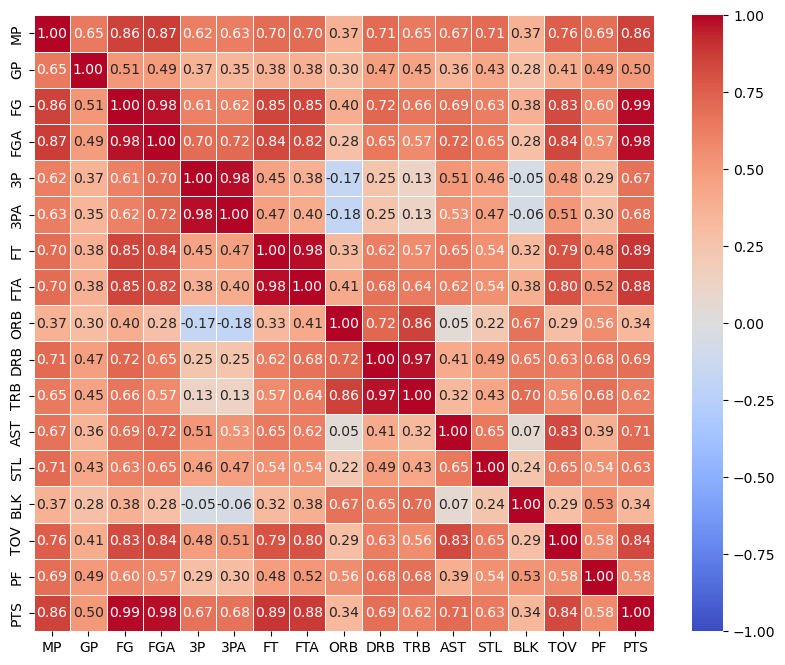

In [8]:
df_cumulative_t = df_cumulative[['MP', 'GP','FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]
df_cumulative_t.corr()

f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_cumulative_t.corr(), 
            annot=True, 
            linewidths=.5, 
            fmt= '.2f',
            ax=ax,
            vmin=-1, 
            vmax=1,
            cmap = "coolwarm")
plt.show()



As we can see the 'MP' (Minutes Played) is positive correlated with all the base stats by a good amount (expecting for the 'BLK' and 'ORB' stats). I want to remove all the stat lines that are not relevant to my analysis, specifically those with few statistics. To do this, I will use the correlation with 'MP'. By imposing a threshold on 'MP', I can discard many stat lines that lack other statistics.

Let's see how the players are distributed by minutes played and number of games played in order to set a proper threshold.

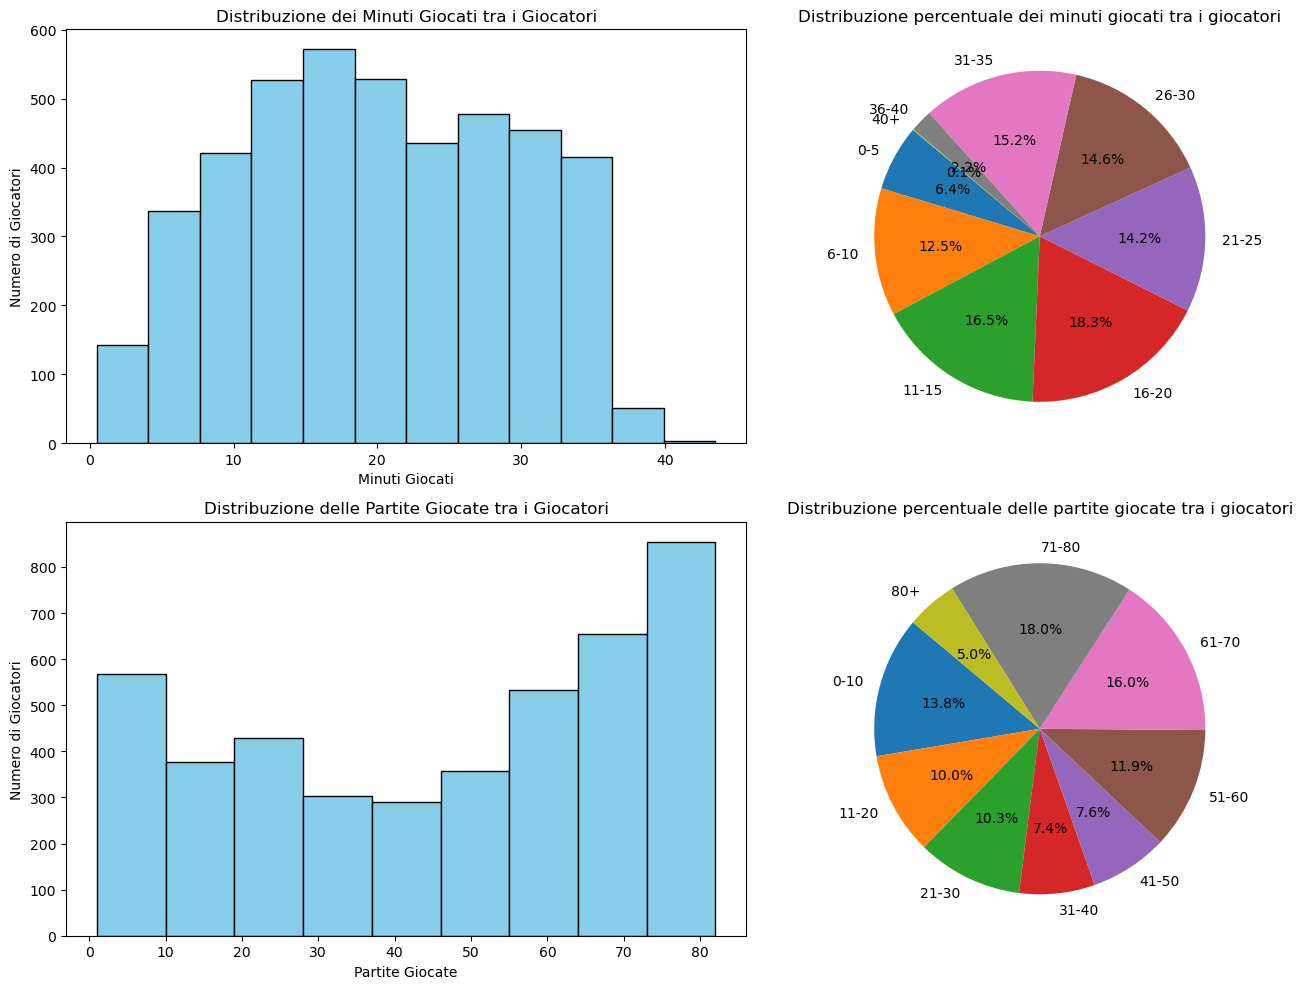

In [9]:
soglie_minuti = [(0, 5), (6, 10), (11, 15), (16, 20), (21, 25), (26, 30), (31, 35), (36, 40), (41, float('inf'))]
soglie_partite = [(0, 10), (11, 20), (21, 30), (31, 40), (41, 50), (51, 60), (61, 70), (71, 80), (81, float('inf'))]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].hist(df_cumulative['MP'], bins=12, color=['skyblue'], edgecolor='black')
axs[0, 0].set_xlabel('Minuti Giocati')
axs[0, 0].set_ylabel('Numero di Giocatori')
axs[0, 0].set_title('Distribuzione dei Minuti Giocati tra i Giocatori')

num_giocatori_per_categoria = []
for soglia in soglie_minuti:
    min_soglia, max_soglia = soglia
    num_giocatori = df_cumulative[(df_cumulative['MP'] >= min_soglia) & (df_cumulative['MP'] <= max_soglia)].shape[0]
    num_giocatori_per_categoria.append(num_giocatori)

percentuali = [(num_giocatori / df_cumulative.shape[0]) * 100 for num_giocatori in num_giocatori_per_categoria]
etichette = ['{}-{}'.format(min_soglia, max_soglia) if max_soglia != float('inf') else '40+' for min_soglia, max_soglia in soglie_minuti]
axs[0, 1].pie(percentuali, labels=etichette, autopct='%1.1f%%', startangle=140)
axs[0, 1].set_title('Distribuzione percentuale dei minuti giocati tra i giocatori')

axs[1, 0].hist(df_cumulative['G'], bins=9, color='skyblue', edgecolor='black')
axs[1, 0].set_xlabel('Partite Giocate')
axs[1, 0].set_ylabel('Numero di Giocatori')
axs[1, 0].set_title('Distribuzione delle Partite Giocate tra i Giocatori')

num_giocatori_per_categoria = []
for soglia in soglie_partite:
    min_soglia, max_soglia = soglia
    num_giocatori = df_cumulative[(df_cumulative['G'] >= min_soglia) & (df_cumulative['G'] <= max_soglia)].shape[0]
    num_giocatori_per_categoria.append(num_giocatori)

percentuali = [(num_giocatori / df_cumulative.shape[0]) * 100 for num_giocatori in num_giocatori_per_categoria]
etichette = ['{}-{}'.format(min_soglia, max_soglia) if max_soglia != float('inf') else '80+' for min_soglia, max_soglia in soglie_partite]
axs[1, 1].pie(percentuali, labels=etichette, autopct='%1.1f%%', startangle=140)
axs[1, 1].set_title('Distribuzione percentuale delle partite giocate tra i giocatori')

plt.tight_layout()
plt.show()

From the graph of minutes played, I can see that:

 - Approximately 21.5% of players play less than 10 minutes per game;
 - 38.5% of players play less than 15 minutes per game;
 - 54.9% of players play less than 20 minutes per game;

From the graph of games played, I can see that:

 - 25.5% play less than a quarter of the seasonal games (82 games in the regular season);
 - 36.6% play fewer than 30 games per season;

For this reason, I can clean the dataset from the data of players who play too little or have too few games throughout the season to avoid anomalous performances or consider players who are less involved in the games.

In [10]:
minutes_threshold = 15.0
mask = df_cumulative['MP'] >= minutes_threshold
df_cumulative = df_cumulative[mask]

games_threshold = 10
mask = df_cumulative['G'] >= games_threshold
df_cumulative = df_cumulative[mask]

Now, the columns associated with games played and average minutes per game are no longer needed, and I can remove them.

In [11]:
df_cumulative = df_cumulative.drop(['GS', 'GP', 'MP', 'G', 'TEAM'], axis=1)
print(df_cumulative.columns)

Index(['AGE', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'POS', 'HEIGHT', 'WEIGHT', 'PER', 'TS%', '3PAr',
       'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
       'OWS', 'DWS', 'OBPM', 'DBPM', 'BPM', 'VORP', 'TOUCHES',
       'FRONT CT TOUCHES', 'TIME OF POSS', 'AVG SEC PER TOUCH',
       'AVG DRIB PER TOUCH', 'PTS PER TOUCH', 'ELBOW TOUCHES', 'POST UPS',
       'PAINT TOUCHES', 'PTS PER ELBOW TOUCH', 'PTS PER POST TOUCH',
       'PTS PER PAINT TOUCH'],
      dtype='object')


#### Data Transformation

At the moment, the data in the 'HEIGHT' column are stored as a string in the format: '6-9' (feet-inches), and the data in the 'WEIGHT' column are in pounds. Let's change the data in the 'HEIGHT' column to numeric values in centimeters and the data in the 'WEIGHT' column to kilograms.

In [12]:
df_cumulative['HEIGHT'] = df_cumulative['HEIGHT'].str.replace('-', '')

df_cumulative['FEET'] = df_cumulative['HEIGHT'].str.slice(0, 1).astype(int)
df_cumulative['INCHES'] = df_cumulative['HEIGHT'].str.slice(1, None).astype(int)

df_cumulative['HEIGHT_CM'] = df_cumulative['FEET'] * 30.48 + df_cumulative['INCHES'] * 2.54

df_cumulative = df_cumulative.drop(columns=['HEIGHT', 'FEET', 'INCHES'])

def lb_to_kg(peso_in_lb):
    peso_in_kg = peso_in_lb * 0.453592
    return peso_in_kg

df_cumulative['WEIGHT_KG'] = df_cumulative['WEIGHT'].apply(lb_to_kg)
df_cumulative = df_cumulative.drop(columns=['WEIGHT'])

### Classification

#### Role Distribution

Let's now see how the various classes are distributed within our dataset to determine if I have a balanced dataset or not.

POS
SG    660
PG    561
PF    553
SF    533
C     476
Name: count, dtype: int64


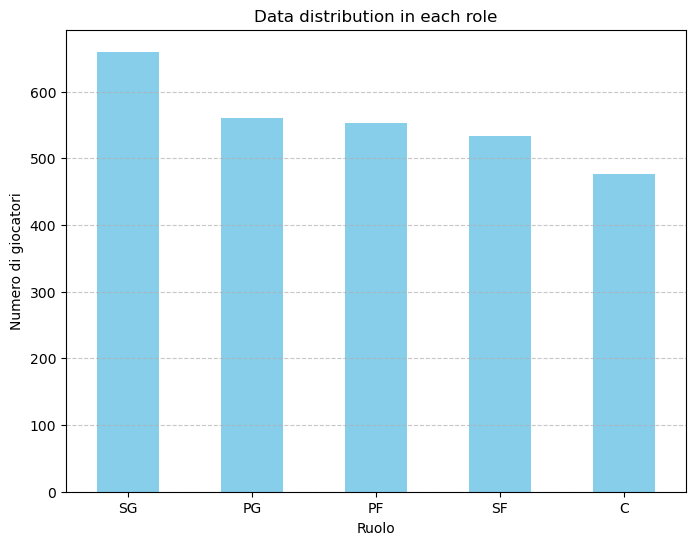

In [13]:
value_counts = df_cumulative['POS'].value_counts()
print(value_counts)

plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Data distribution in each role')
plt.xlabel('Ruolo')
plt.ylabel('Numero di giocatori')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

As we can see, the dataset used for classification is quite small (2635 elements) and is not perfectly balanced. The number of players in the most common position (SG, with 613 players) exceeds that of the least common position (C, with 450) by 163 elements, a discrepancy of approximately 36%!

We'll need to take this disproportion into account within the dataset by using class rebalancing techniques.

#### Role Prediction using a balanced Dataset

I'm using *imblearn* to balance the dataset (which is skewed towards the PG role).

I always use SelectKBest to select the best features.
I use StratifiedKFold to perform multiple training runs.

I perform an initial test with a basic classification model (KNeighborsClassifier), and then compare it with different models.

In [14]:
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_validate, StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


X = df_cumulative[['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'HEIGHT_CM', 'WEIGHT_KG', 'PER', 'TS%', '3PAr', 'FTr',
       'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'AGE', 'USG%', 'OWS',
       'DWS', 'OBPM', 'DBPM', 'BPM', 'VORP', 'TOUCHES', 'FRONT CT TOUCHES',
       'TIME OF POSS', 'AVG SEC PER TOUCH', 'AVG DRIB PER TOUCH',
       'PTS PER TOUCH', 'ELBOW TOUCHES', 'POST UPS', 'PAINT TOUCHES',
       'PTS PER ELBOW TOUCH', 'PTS PER POST TOUCH', 'PTS PER PAINT TOUCH']]
y = df_cumulative['POS']

X_dense = X.values

skf = StratifiedKFold(10, shuffle = True, random_state = 21)

estimators = [('sampling',SMOTE()),
              ('feature-selection',SelectKBest(k=15)), 
              ('Classification', KNeighborsClassifier(3))]
pipe = Pipeline(estimators)
pipe

res = {'f1_score': 'f1_macro',
          'precision': make_scorer(precision_score, average='macro'),
          'recall': make_scorer(recall_score, average='macro')}

results = cross_validate(pipe, X_dense, y,
                         scoring = res,
                         cv = skf,
                         n_jobs = -1)
print(results)

{'fit_time': array([0.4748261 , 0.49291325, 0.51536107, 0.49252939, 0.49128771,
       0.50082541, 0.47749424, 0.50296497, 0.30915046, 0.27328849]), 'score_time': array([0.09610033, 0.10019231, 0.08792162, 0.10814071, 0.10168076,
       0.06497884, 0.08603525, 0.07806325, 0.04707837, 0.05760002]), 'test_f1_score': array([0.68912119, 0.7281131 , 0.76006803, 0.73591763, 0.7607513 ,
       0.73815299, 0.68828061, 0.74658157, 0.76905299, 0.75307639]), 'test_precision': array([0.68924749, 0.72908083, 0.76098675, 0.7384188 , 0.7607149 ,
       0.73741067, 0.69244815, 0.7472645 , 0.76851701, 0.75377798]), 'test_recall': array([0.69679853, 0.73285105, 0.7601509 , 0.73479886, 0.76274994,
       0.73945602, 0.69579801, 0.74716246, 0.77343135, 0.76149758])}


### Features Importance

I examine which features hold the most importance in the classification process using the RandomForestClassifier model. This analysis allows me to rank the statistics by importance and understand which of the three groups of statistics—biometric, basic, and advanced—are the most useful.

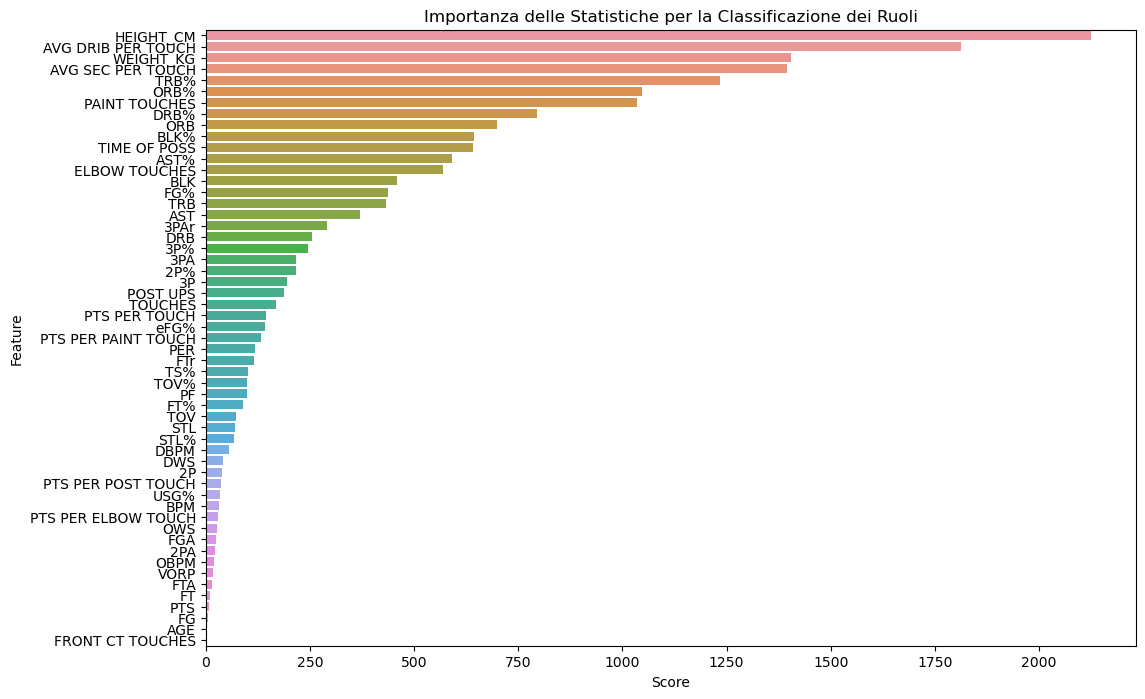

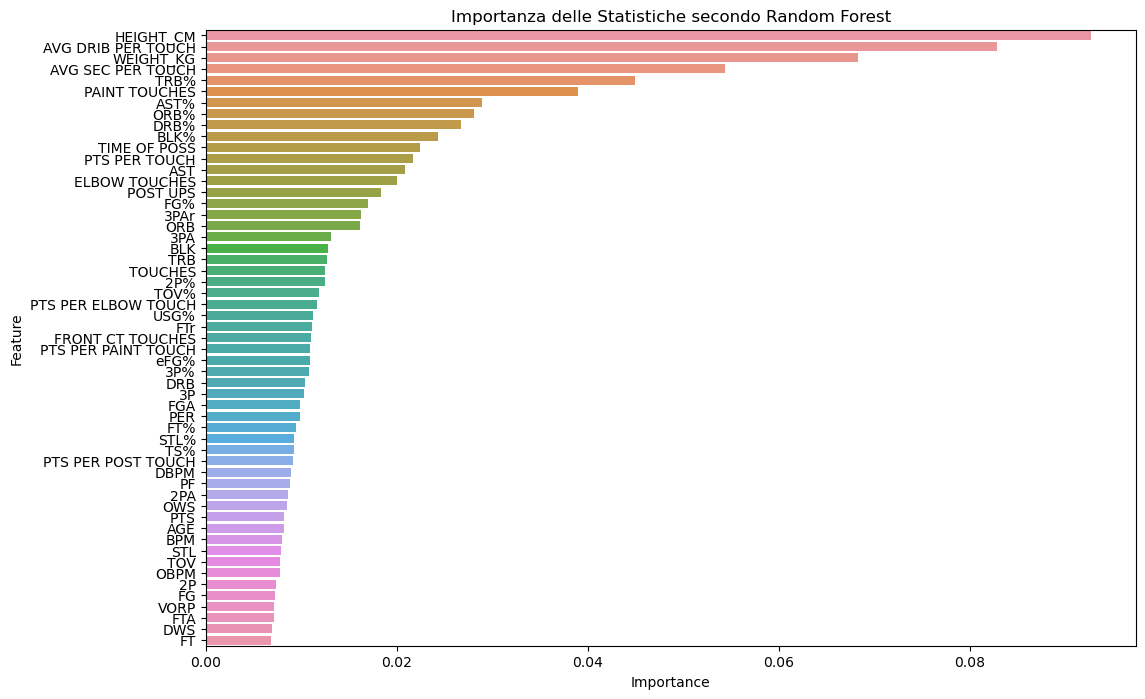

Principali statistiche per il ruolo SG:
HEIGHT_CM             194.406212
AVG DRIB PER TOUCH      2.325667
WEIGHT_KG              92.509401
AVG SEC PER TOUCH       2.986879
TRB%                    6.709091
PAINT TOUCHES           0.991970
AST%                   13.602879
ORB%                    2.422727
DRB%                   11.007121
BLK%                    0.998030
dtype: float64


Principali statistiche per il ruolo PF:
HEIGHT_CM             204.407993
AVG DRIB PER TOUCH      0.999241
WEIGHT_KG             106.766370
AVG SEC PER TOUCH       2.023635
TRB%                   12.090416
PAINT TOUCHES           3.171248
AST%                   11.144485
ORB%                    6.014286
DRB%                   18.165099
BLK%                    2.031284
dtype: float64


Principali statistiche per il ruolo C:
HEIGHT_CM             209.907521
AVG DRIB PER TOUCH      0.554916
WEIGHT_KG             112.816716
AVG SEC PER TOUCH       1.695966
TRB%                   16.285924
PAINT TOUCHES         

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import shap

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dense)

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_scaled, y)
scores = selector.scores_

feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores)
plt.title('Importanza delle Statistiche per la Classificazione dei Ruoli')
plt.show()

model = RandomForestClassifier()
model.fit(X_scaled, y)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_scaled)

importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importanza delle Statistiche secondo Random Forest')
plt.show()

top_features = importance_df.head(10)['Feature'].tolist()
for role in y.unique():
    print(f'Principali statistiche per il ruolo {role}:')
    role_data = df_cumulative[df_cumulative['POS'] == role]
    print(role_data[top_features].mean())
    print('\n')

The most relevant statistics are divided into:

   - Biometric characteristics: weight and height of the player play a fundamental role in the classification process by role;
   - Numerous advanced statistics: such as 'AVG DRIB PER TOUCH', 'TRB%', 'AST%', 'PAINT TOUCHES', etc.

For each role, among the ten most relevant statistics, I do not find any basic statistics. This indicates that advanced statistics are very helpful in defining more complex gameplay characteristics.

#### Comparison between different classifiers

I compare different classification models. Specifically, I have considered the following models:

   - RandomForestClassifier();
   - DecisionTreeClassifier();
   - LogisticRegression();
   - KNeighborsClassifier();
   - SVC();
   - GradientBoostingClassifier();

The performance metrics considered are F1_score, Recall, and Precision.

I also decided to test various classifiers by varying the parameter k in the selection of the most significant features *(SelectKBest())*. At the end of the analysis, I will use the k for which I have the most performant model in terms of F1_score.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from tabulate import tabulate

classifiers = [RandomForestClassifier(), DecisionTreeClassifier(), LogisticRegression(), KNeighborsClassifier(), SVC(), GradientBoostingClassifier()]

SelectKBest_param = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]

cumulative_results = pd.DataFrame()

for k_p in SelectKBest_param:
    results_list = []

    for clf in classifiers:
        estimators = [('sampling',SMOTE()),
                      ('feature-selection',SelectKBest(k=k_p)), 
                      ('Classification', clf)]
        pipe = Pipeline(estimators)

        results = cross_validate(pipe, X_scaled, y,
                                 scoring=res,
                                 cv=skf,
                                 n_jobs=-1)

        results_list.append({
            "K" : k_p,
            "Classifier": clf.__class__.__name__,
            "F1 Score": results['test_f1_score'],
            "Precision": results['test_precision'],
            "Recall": results['test_recall']
        })
        

    results_df = pd.DataFrame(results_list)
    
    cumulative_results = pd.concat([cumulative_results,results_df])

    d = {
        'Classifier': results_df['Classifier'], 
         'F1 Score Mean' : results_df['F1 Score'].apply(np.mean), 
         'Precision Mean' : results_df['Precision'].apply(np.mean),
         'Recall Mean' : results_df['Recall'].apply(np.mean)}
    results_mean = pd.DataFrame(d)
    
    print('------------------------------------------------')
    print('N. Selected Features: ', k_p)
    print(tabulate(results_mean, headers='keys', tablefmt='pretty'))

------------------------------------------------
N. Selected Features:  5
+---+----------------------------+--------------------+--------------------+--------------------+
|   |         Classifier         |   F1 Score Mean    |   Precision Mean   |    Recall Mean     |
+---+----------------------------+--------------------+--------------------+--------------------+
| 0 |   RandomForestClassifier   | 0.753042781470331  | 0.7557231540514484 | 0.7554471029657808 |
| 1 |   DecisionTreeClassifier   | 0.6744730556812345 | 0.6780469938457029 | 0.6748647987162534 |
| 2 |     LogisticRegression     | 0.6350992803948194 | 0.6357288633954121 | 0.6408725774449748 |
| 3 |    KNeighborsClassifier    | 0.7437035645976947 | 0.7450353578667762 | 0.7477470483065889 |
| 4 |            SVC             | 0.6717688237853887 | 0.678136414062056  | 0.6775896125014635 |
| 5 | GradientBoostingClassifier | 0.7488283103307499 | 0.7500280923797201 | 0.750612567131245  |
+---+----------------------------+----------

------------------------------------------------
N. Selected Features:  45
+---+----------------------------+--------------------+--------------------+--------------------+
|   |         Classifier         |   F1 Score Mean    |   Precision Mean   |    Recall Mean     |
+---+----------------------------+--------------------+--------------------+--------------------+
| 0 |   RandomForestClassifier   | 0.7890859956617986 | 0.7906239494097352 | 0.790472829654415  |
| 1 |   DecisionTreeClassifier   | 0.6922761728696326 | 0.6951897137827107 |  0.6912126003909   |
| 2 |     LogisticRegression     | 0.6876840145097876 | 0.6898253286423708 | 0.6903319392459877 |
| 3 |    KNeighborsClassifier    | 0.7341660742713784 | 0.7359053242599238 | 0.7360461633908093 |
| 4 |            SVC             | 0.7104289882276495 | 0.7168502297117538 | 0.7163690132226705 |
| 5 | GradientBoostingClassifier | 0.7724510570470365 | 0.7732108239457591 | 0.7734369969733119 |
+---+----------------------------+---------

Considering the average F1 Score values as the main metric, I notice that the values vary by a few tenths of a percent as k changes, performing best for k=35 in the case of the RandomForestClassifier (best result obtained with 75.88%). I will check if the differences between the various models are statistically significant for the case with k=35.

#### Statistical test

I perform a statistical test to see which classifier stands out statistically from the others.

In [23]:
from scipy.stats import wilcoxon
import itertools

results_df = cumulative_results[cumulative_results['K'] == 35]

scores = [0, 0, 0, 0, 0, 0]
f1_scores = results_df['F1 Score']

alpha = 0.05
n_classifiers = 6
critical_value = alpha / n_classifiers
n_classifier = 6

for i in range(n_classifiers):
    for j in range(i+1, n_classifiers):
        stat, p_value = wilcoxon(f1_scores[i], f1_scores[j])
        if p_value < critical_value:
            if f1_scores[i].mean() > f1_scores[j].mean():
                scores[i] += 1
            else:
                scores[j] += 1

max_value = max(scores)
max_indices = [i for i, val in enumerate(scores) if val == max_value]

print('The classifiers that have statistically the best performance are:')
for i in max_indices:
    print(classifiers[i].__class__.__name__)

The classifiers that have statistically the best performance are:
RandomForestClassifier
GradientBoostingClassifier


#### Hyperparameters tuning

After identifying the classifier that performs best with its default configuration, I attempt to tune the hyperparameters to see if we can achieve performance improvement.

The classifier model on which the analysis was conducted is RandomForestClassifier, and the chosen parameters for optimization are: 'n_estimators', 'max_depth', 'min_samples_split' (three possible values were chosen for each parameter to avoid excessive search).

Tuning was performed using nested cross-validation and grid search.

In [24]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

NUM_TRIALS = 10


p_grid = {"n_estimators": [10, 50, 100], 
          "max_depth": [None, 10, 20], 
          "min_samples_split": [2, 5, 10]}

svm = classifiers[max_indices[0]]

In [25]:
from sklearn.base import clone
from collections import Counter

scores = np.zeros(NUM_TRIALS)

best_params_list = []

for i in range(NUM_TRIALS):

    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=skf) 
    
    clf.fit(X_dense, y)
    
    print(clf.best_params_)

    best_params_list.append(clf.best_params_)


best_params_counter = Counter(frozenset(param.items()) for param in best_params_list)
best_params_common = dict(best_params_counter.most_common(1)[0][0])    
    
final_model = RandomForestClassifier(**best_params_common, random_state=42)

estimators = [('sampling',SMOTE()),
                  ('feature-selection',SelectKBest(k=35)), 
                  ('Classification', final_model)]
pipe = Pipeline(estimators)
    
results = cross_validate(pipe, X_dense, y,
                        scoring=res,
                        cv=skf,
                        n_jobs=-1)

{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}


In [26]:
res = pd.DataFrame(results)

d = {'F1 Score Mean' : res['test_f1_score'],
                      'Precision Mean' : res['test_precision'],
                      'Recall Mean' : res['test_recall']}

first_row = results_mean.iloc[0]

first_row = first_row.rename({
    'Classifier': 'Version'
})
first_row['Version'] = 'Base'

row_df = pd.DataFrame(first_row)

res_df = pd.DataFrame(d)
res_df_mean = res_df.mean()
res_df_mean['Version'] = 'Optimized'
print(first_row)
print(res_df_mean)


Version               Base
F1 Score Mean     0.787164
Precision Mean    0.788376
Recall Mean       0.789658
Name: 0, dtype: object
F1 Score Mean      0.781439
Precision Mean     0.781974
Recall Mean        0.783746
Version           Optimized
dtype: object


From the results obtained, I can see that by performing a hyperparameters tuning operation, we achieved a slight improvement in the model's performance, reaching a score of 78%.

## ##  Analysis of the dataset PerGame Dataset

Now I'm going to perform the same procedures on the second dataset. Unlike the first one, this dataset contains many more entries but fewer attributes, as it consists only of basic statistics.

In this case, I extract data from just two tables:

   - 'player_game_logs' containing individual stat lines for each game for every player in the league;
   - 'team_roster' for the player's biographical data;

To merge the two tables, I perform some data transformation operations first, specifically:

   - In the data from the 'player_game_logs' table, the 'TEAM' field contains the team's abbreviation rather than the name as in all tables seen so far; therefore, I perform a replace operation for all elements, replacing the abbreviation with the name following the 'teams_dict_fullName' dictionary.
   - In the data from the 'player_game_logs' table, the 'SEASON' field is missing. Therefore, I modify the format of the 'DATE' field to date_format, and for all values with dates later than 2023/09/01, I insert the 'SEASON' field with the value 2024 (in our analysis, we only consider data from the last played season).


In [28]:
teams_dict_fullName = {
    "ATLANTA HAWKS": "ATL",
    "ST. LOUIS HAWKS": "SLH",
    "MILWAUKEE HAWKS": "MIL",
    "TRI-CITIES BLACKHAWKS": "TCB",
    "BOSTON CELTICS": "BOS",
    "BROOKLYN NETS": "BRK",
    "NEW JERSEY NETS": "NJN",
    "CHICAGO BULLS": "CHI",
    "CHARLOTTE HORNETS": "CHH",
    "CHARLOTTE HORNETS": "CHO",
    "CHARLOTTE BOBCATS": "CHA",
    "CLEVELAND CAVALIERS": "CLE",
    "DALLAS MAVERICKS": "DAL",
    "DENVER NUGGETS": "DEN",
    "DETROIT PISTONS": "DET",
    "FORT WAYNE PISTONS": "FWP",
    "GOLDEN STATE WARRIORS": "GSW",
    "SAN FRANCISCO WARRIORS": "SFW",
    "PHILADELPHIA WARRIORS": "PHI",
    "HOUSTON ROCKETS": "HOU",
    "INDIANA PACERS": "IND",
    "LOS ANGELES CLIPPERS": "LAC",
    "SAN DIEGO CLIPPERS": "SDC",
    "BUFFALO BRAVES": "BUF",
    "LOS ANGELES LAKERS": "LAL",
    "MINNEAPOLIS LAKERS": "MIN",
    "MEMPHIS GRIZZLIES": "MEM",
    "VANCOUVER GRIZZLIES": "VAN",
    "MIAMI HEAT": "MIA",
    "MILWAUKEE BUCKS": "MIL",
    "MINNESOTA TIMBERWOLVES": "MIN",
    "NEW ORLEANS PELICANS": "NOP",
    "NEW ORLEANS/OKLAHOMA CITY HORNETS": "NOK",
    "NEW ORLEANS HORNETS": "NOH",
    "NEW YORK KNICKS": "NYK",
    "OKLAHOMA CITY THUNDER": "OKC",
    "SEATTLE SUPERSONICS": "SEA",
    "ORLANDO MAGIC": "ORL",
    "PHILADELPHIA 76ERS": "PHI",
    "SYRACUSE NATIONALS": "SYR",
    "PHOENIX SUNS": "PHO",
    "PORTLAND TRAIL BLAZERS": "POR",
    "SACRAMENTO KINGS": "SAC",
    "KANSAS CITY KINGS": "KCK",
    "KANSAS CITY-OMAHA KINGS": "KCK",
    "CINCINNATI ROYALS": "CIN",
    "ROCHESTER ROYALS": "ROR",
    "SAN ANTONIO SPURS": "SAS",
    "TORONTO RAPTORS": "TOR",
    "UTAH JAZZ": "UTA",
    "NEW ORLEANS JAZZ": "NOJ",
    "WASHINGTON WIZARDS": "WAS",
}

teams_dict_fullname_inverted = {v: k for k, v in teams_dict_fullName.items()}

df_game = get_data('player_game_logs')

df_game['DATE'] = pd.to_datetime(df_game['DATE'])

df_game = df_game[df_game['DATE'] > '2022-01-01']
df_game['TEAM'] = df_game['TEAM'].replace(teams_dict_fullname_inverted)
df_game['SEASON'] = 2024
df_game_log = pd.merge(df_game, df_roster, on=['PLAYER', 'SEASON', 'TEAM'], how='inner')

Data read successfully


### Data Preprocessing

As in the analysis of the first dataset, I perform data cleaning on the dataset.

Firstly, I remove columns that do not contain useful stat lines. In this case, entries are recorded even for instances when the player did not play the game for various reasons; in such cases, all attributes associated with game statistics contain a string indicating the reason why the player did not appear on the field ('Inactive', 'Did Not Play', 'Did Not Dress', and 'Player Suspended').

Next, I remove all columns not used in our analysis (those not related to game statistics, minutes played, and player position).

I then convert the 'MP' (Minutes Played) column as it is in string format ('minutes') in the dataset; I convert it into numerical data.

In [29]:
print(df_game_log.columns)
df_game_log = df_game_log[df_game_log['FG'] != 'Inactive']
df_game_log = df_game_log[df_game_log['FG'] != 'Did Not Play']
df_game_log = df_game_log[df_game_log['FG'] != 'Did Not Dress']
df_game_log = df_game_log[df_game_log['FG'] != 'Player Suspended']
df_game_log = df_game_log[df_game_log['+/-'] != None]
df_game_log = df_game_log.drop(['DATE', 'AGE', 'GS', 'TEAM', 'HOME/AWAY', 'OPPONENT', 'RESULT', 'GAME_SCORE', 'PLAYER', 'SEASON', 'NUMBER', 'BIRTH_DATE', 'NATIONALITY', 'EXPERIENCE', 'COLLEGE'], axis = 1)
numeric_columns = ['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '+/-']
for column in numeric_columns:
    df_game_log[column] = pd.to_numeric(df_game_log[column], errors='coerce')
def convert_to_minutes(mp):
    try:
        minutes, seconds = map(int, mp.split(':'))
        return minutes + seconds / 60
    except:
        return None

df_game_log['MP'] = df_game_log['MP'].apply(convert_to_minutes)

Index(['DATE', 'AGE', 'TEAM', 'HOME/AWAY', 'OPPONENT', 'RESULT', 'GS', 'MP',
       'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GAME_SCORE',
       '+/-', 'PLAYER', 'SEASON', 'NUMBER', 'POS', 'HEIGHT', 'WEIGHT',
       'BIRTH_DATE', 'NATIONALITY', 'EXPERIENCE', 'COLLEGE'],
      dtype='object')


I modify the values of the columns related to shooting percentages to handle NaN cases as done in the first dataset.

In [30]:
df_game_log.loc[df_game_log['FGA'] == 0.0, 'FG%'] = 0
df_game_log.loc[df_game_log['3PA'] == 0.0, '3P%'] = 0
df_game_log.loc[df_game_log['FTA'] == 0.0, 'FT%'] = 0
na_counts = df_game_log.isna().sum()
columns_with_na = na_counts[na_counts > 0]
print(columns_with_na)

MP     57
FG     57
FGA    57
FG%    57
3P     57
3PA    57
3P%    57
FT     57
FTA    57
FT%    57
ORB    57
DRB    57
TRB    57
AST    57
STL    57
BLK    57
TOV    57
PF     57
PTS    57
+/-    61
dtype: int64


In this case as well, I remove the data of players who have played for less than a certain threshold (15 minutes).

In [31]:
minutes_threshold = 15.0
mask = df_game_log['MP'] >= minutes_threshold
df_game_log = df_game_log[mask]
na_counts = df_game_log.isna().sum()
columns_with_na = na_counts[na_counts > 0]
print(columns_with_na)

Series([], dtype: int64)


I modify the 'HEIGHT' and 'WEIGHT' columns to convert the format from string to numeric and from American format to international format.

In [32]:
df_game_log['HEIGHT'] = df_game_log['HEIGHT'].str.replace('-', '')

df_game_log['FEET'] = df_game_log['HEIGHT'].str.slice(0, 1).astype(int)
df_game_log['INCHES'] = df_game_log['HEIGHT'].str.slice(1, None).astype(int)

df_game_log['HEIGHT_CM'] = df_game_log['FEET'] * 30.48 + df_game_log['INCHES'] * 2.54

df_game_log = df_game_log.drop(columns=['HEIGHT', 'FEET', 'INCHES'])

def lb_to_kg(peso_in_lb):
    peso_in_kg = peso_in_lb * 0.453592
    return peso_in_kg

df_game_log['WEIGHT_KG'] = df_game_log['WEIGHT'].apply(lb_to_kg)
df_game_log = df_game_log.drop(columns=['WEIGHT'])

### Classification

I see how balanced the dataset is across the various classes (player positions).

POS
PF    2535
PG    2421
SF    2358
SG    2343
C     2252
Name: count, dtype: int64


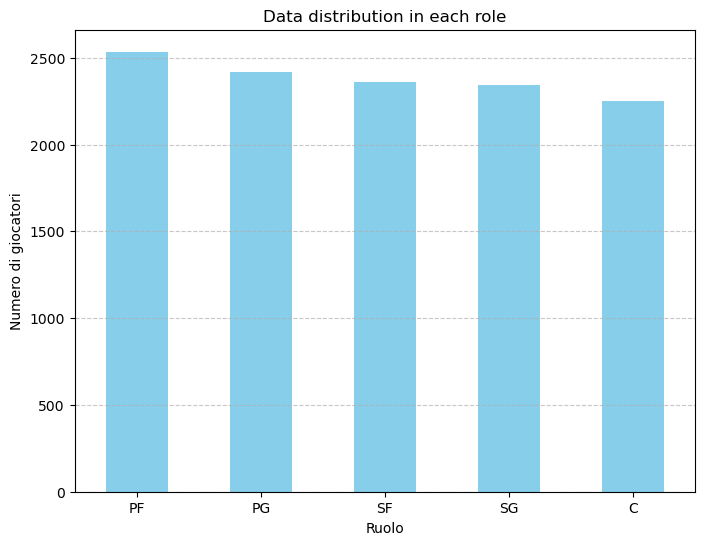

In [33]:
value_counts = df_game_log['POS'].value_counts()
print(value_counts)

plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Data distribution in each role')
plt.xlabel('Ruolo')
plt.ylabel('Numero di giocatori')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In this case as well, the dataset is slightly unbalanced, although with less impact compared to the first dataset.

I'm using imblearn to balance the dataset (which is skewed towards the PG role).

I always use SelectKBest to select the best features.
I use StratifiedKFold to perform multiple training runs.

I perform an initial test with a basic classification model (KNeighborsClassifier), and then compare it with different models.

In [43]:
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_validate, StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X = df_game_log[['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 
                   'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'WEIGHT_KG', 'HEIGHT_CM']]
y = df_game_log['POS']

X_dense = X.values

skf = StratifiedKFold(10, shuffle = True, random_state = 21)

estimators = [('sampling',SMOTE()),
              ('feature-selection',SelectKBest(k=15)), 
              ('Classification', KNeighborsClassifier(3))]
pipe = Pipeline(estimators)
pipe

res = {'f1_score': 'f1_macro',
          'precision': make_scorer(precision_score, average='macro'),
          'recall': make_scorer(recall_score, average='macro')}

results = cross_validate(pipe, X_dense, y,
                         scoring = res,
                         cv = skf,
                         n_jobs = -1)
print(results)

{'fit_time': array([1.05768347, 1.07669091, 1.05367517, 1.14925361, 1.10968113,
       1.1207006 , 1.06069326, 1.07468224, 0.47582603, 0.45684361]), 'score_time': array([0.36773133, 0.291713  , 0.41249299, 0.30190468, 0.42806458,
       0.28170276, 0.36971402, 0.31670594, 0.21209216, 0.20208645]), 'test_f1_score': array([0.79980521, 0.79128611, 0.7886345 , 0.81537752, 0.78889653,
       0.81425271, 0.79967969, 0.79208492, 0.7913416 , 0.80627609]), 'test_precision': array([0.79916719, 0.79217874, 0.78934086, 0.81535947, 0.78842008,
       0.81389456, 0.79963599, 0.79209405, 0.79136547, 0.80718679]), 'test_recall': array([0.80084897, 0.79186848, 0.78849656, 0.81568685, 0.79021807,
       0.81555561, 0.80116536, 0.79352414, 0.79153419, 0.80630265])}


### Features Importance

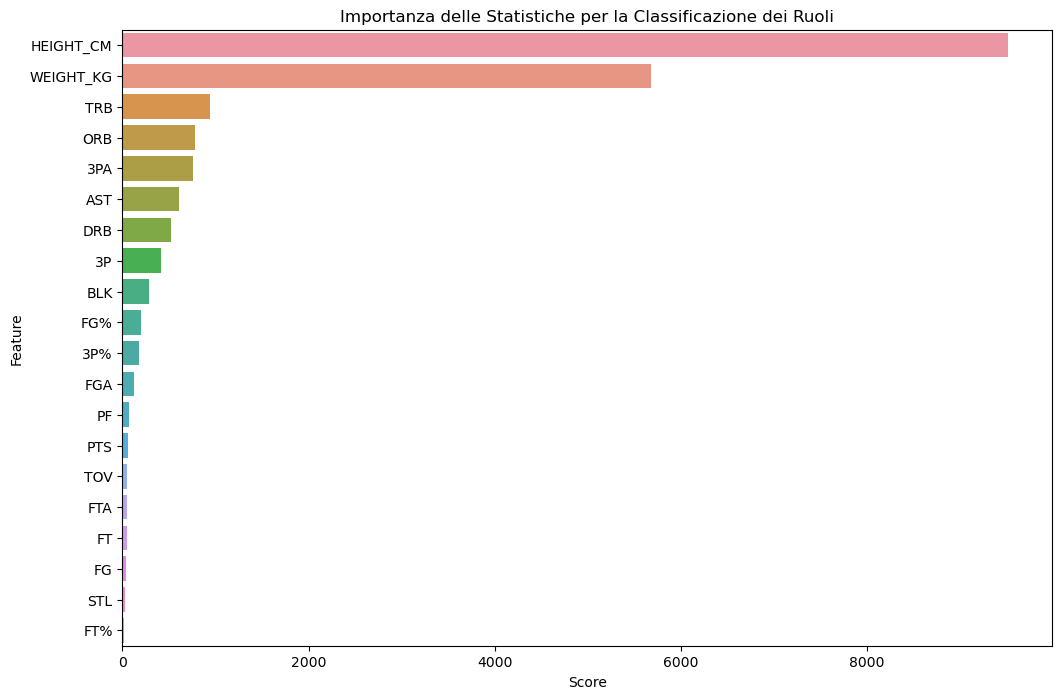

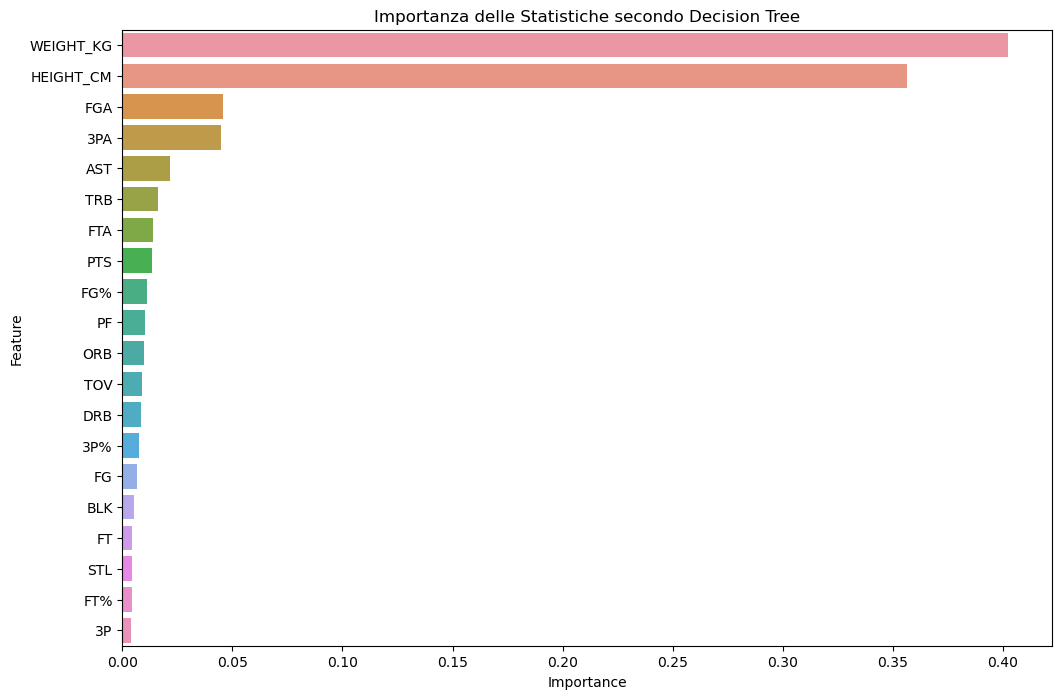

Principali statistiche per il ruolo PF:
WEIGHT_KG    104.580959
HEIGHT_CM    204.246059
FGA           11.035108
3PA            3.861538
AST            2.838659
TRB            5.874951
FTA            3.125444
PTS           15.016174
FG%            0.497507
PF             2.028797
dtype: float64


Principali statistiche per il ruolo PG:
WEIGHT_KG     88.876865
HEIGHT_CM    190.018439
FGA           13.125568
3PA            5.604296
AST            5.763321
TRB            3.935564
FTA            3.280050
PTS           16.990913
FG%            0.452830
PF             1.885584
dtype: float64


Principali statistiche per il ruolo SF:
WEIGHT_KG     97.022521
HEIGHT_CM    199.205802
FGA           10.481340
3PA            4.558524
AST            2.537744
TRB            4.564037
FTA            2.358779
PTS           13.249364
FG%            0.453331
PF             2.098813
dtype: float64


Principali statistiche per il ruolo C:
WEIGHT_KG    113.924505
HEIGHT_CM    210.323730
FGA            9.47646

In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import shap

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dense)

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_scaled, y)
scores = selector.scores_

feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores)
plt.title('Importanza delle Statistiche per la Classificazione dei Ruoli')
plt.show()

model = DecisionTreeClassifier()
model.fit(X_scaled, y)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_scaled)

importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importanza delle Statistiche secondo Decision Tree')
plt.show()

top_features = importance_df.head(10)['Feature'].tolist()
for role in y.unique():
    print(f'Principali statistiche per il ruolo {role}:')
    role_data = df_game_log[df_game_log['POS'] == role]
    print(role_data[top_features].mean())
    print('\n')

### Model Selection

I compare different classification models. Specifically, I have considered the following models:

   - RandomForestClassifier();
   - DecisionTreeClassifier();
   - LogisticRegression();
   - KNeighborsClassifier();
   - SVC();
   - GradientBoostingClassifier();

The performance metrics considered are F1_score, Recall, and Precision.

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from tabulate import tabulate

classifiers = [RandomForestClassifier(), DecisionTreeClassifier(), LogisticRegression(), KNeighborsClassifier(), SVC(), GradientBoostingClassifier()]

SelectKBest_param = [5, 10, 15, 20]

cumulative_results = pd.DataFrame()

for k_p in SelectKBest_param:
    results_list = []

    for clf in classifiers:
        estimators = [('sampling',SMOTE()),
                      ('feature-selection',SelectKBest(k=k_p)), 
                      ('Classification', clf)]
        pipe = Pipeline(estimators)

        results = cross_validate(pipe, X_scaled, y,
                                 scoring=res,
                                 cv=skf,
                                 n_jobs=-1)

        results_list.append({
            "K" : k_p,
            "Classifier": clf.__class__.__name__,
            "F1 Score": results['test_f1_score'],
            "Precision": results['test_precision'],
            "Recall": results['test_recall']
        })
        
    results_df = pd.DataFrame(results_list)
    
    cumulative_results = pd.concat([cumulative_results,results_df])

    d = {
        'Classifier': results_df['Classifier'], 
         'F1 Score Mean' : results_df['F1 Score'].apply(np.mean), 
         'Precision Mean' : results_df['Precision'].apply(np.mean),
         'Recall Mean' : results_df['Recall'].apply(np.mean)}
    results_mean = pd.DataFrame(d)
    
    print('------------------------------------------------')
    print('N. Selected Features: ', k_p)
    print(tabulate(results_mean, headers='keys', tablefmt='pretty'))

------------------------------------------------
N. Selected Features:  5
+---+----------------------------+--------------------+--------------------+--------------------+
|   |         Classifier         |   F1 Score Mean    |   Precision Mean   |    Recall Mean     |
+---+----------------------------+--------------------+--------------------+--------------------+
| 0 |   RandomForestClassifier   | 0.8966555122545333 | 0.8970164845300227 | 0.8967436198972306 |
| 1 |   DecisionTreeClassifier   | 0.8937138858783328 | 0.8940472172552987 | 0.8938593947803837 |
| 2 |     LogisticRegression     | 0.6668261491979494 | 0.6680015080143629 | 0.6673343229306792 |
| 3 |    KNeighborsClassifier    | 0.746576250300186  | 0.7474984083072521 | 0.7473437065446122 |
| 4 |            SVC             | 0.7220044050472841 | 0.732275145538533  | 0.7210107614484372 |
| 5 | GradientBoostingClassifier | 0.8814509200004549 | 0.8830749015071936 | 0.8810524671013322 |
+---+----------------------------+----------

I perform a statistical test to see which classifier stands out statistically from the others selecting the results for the k that resulted with the best performance (k = 15).

In [37]:
from scipy.stats import wilcoxon
import itertools

results_df = cumulative_results[cumulative_results['K'] == 15]

scores = [0, 0, 0, 0, 0, 0]
f1_scores = results_df['F1 Score']
alpha = 0.05
n_classifiers = 6
critical_value = alpha / n_classifiers
n_classifier = 6

for i in range(n_classifiers):
    for j in range(i+1, n_classifiers):
        stat, p_value = wilcoxon(f1_scores[i], f1_scores[j])
        if p_value < critical_value:
            if f1_scores[i].mean() > f1_scores[j].mean():
               scores[i] += 1
            else:
               scores[j] += 1


max_value = max(scores)
max_indices = [i for i, val in enumerate(scores) if val == max_value]

print('The classifiers that have statistically the best performance are:')
for i in max_indices:
    print(classifiers[i].__class__.__name__)

The classifiers that have statistically the best performance are:
DecisionTreeClassifier


#### Hyperparameters tuning

After identifying the classifier that performs best with its default configuration, I attempt to tune the hyperparameters to see if we can achieve performance improvement.

The classifier model on which the analysis was conducted is DecisionTreeClassifier, and the chosen parameters for optimization are: 'max_depth', 'max_depth', 'min_samples_split', 'min_samples_leaf' (three possible values were chosen for each parameter to avoid excessive search).

Tuning was performed using nested cross-validation and grid search.

In [38]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

NUM_TRIALS = 10

p_grid = {
    "max_depth": [None, 5, 15, 30],
    "min_samples_split": [2, 5, 10, 25],
    "min_samples_leaf": [1, 2, 4, 8]
}

svm = DecisionTreeClassifier()

In [39]:
from sklearn.base import clone
from collections import Counter

scores = np.zeros(NUM_TRIALS)

best_params_list = []

for i in range(NUM_TRIALS):

    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=skf) 
    
    clf.fit(X_dense, y)
    
    print(clf.best_params_)

    best_params_list.append(clf.best_params_)

best_params_counter = Counter(frozenset(param.items()) for param in best_params_list)
best_params_common = dict(best_params_counter.most_common(1)[0][0])    
    
final_model = DecisionTreeClassifier(**best_params_common)

estimators = [('sampling',SMOTE()),
                  ('feature-selection',SelectKBest(k=15)), 
                  ('Classification', final_model)]
pipe = Pipeline(estimators)

res = {'f1_score': 'f1_macro',
          'precision': make_scorer(precision_score, average='macro'),
          'recall': make_scorer(recall_score, average='macro')}

results = cross_validate(pipe, X_dense, y,
                        scoring=res,
                        cv=skf,
                        n_jobs=-1)

{'max_depth': 30, 'min_samples_leaf': 8, 'min_samples_split': 2}
{'max_depth': 30, 'min_samples_leaf': 8, 'min_samples_split': 10}
{'max_depth': 30, 'min_samples_leaf': 8, 'min_samples_split': 5}
{'max_depth': 30, 'min_samples_leaf': 8, 'min_samples_split': 10}
{'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10}
{'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 10}
{'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 2}
{'max_depth': 30, 'min_samples_leaf': 8, 'min_samples_split': 2}
{'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 2}
{'max_depth': 30, 'min_samples_leaf': 8, 'min_samples_split': 2}


In [40]:
res = pd.DataFrame(results)

d = {'F1 Score Mean' : res['test_f1_score'],
                      'Precision Mean' : res['test_precision'],
                      'Recall Mean' : res['test_recall']}

first_row = results_mean.iloc[max_indices]

print(first_row)

first_row = first_row.rename({
    'Classifier': 'Version'
})
first_row['Version'] = 'Base'

row_df = pd.DataFrame(first_row)

res_df = pd.DataFrame(d)
res_df_mean = res_df.mean()
res_df_mean['Version'] = 'Optimized'
print(first_row)
print(res_df_mean)


               Classifier  F1 Score Mean  Precision Mean  Recall Mean
1  DecisionTreeClassifier       0.896156        0.896584     0.896117
               Classifier  F1 Score Mean  Precision Mean  Recall Mean Version
1  DecisionTreeClassifier       0.896156        0.896584     0.896117    Base
F1 Score Mean      0.904083
Precision Mean     0.904219
Recall Mean        0.904266
Version           Optimized
dtype: object


## Comments on the results and Conclusion

The results obtained from the first dataset show that the best classifier in terms of F1_score is the RandomForestClassifier, with the k parameter used for configuring SelectKBest being 35 features. After hyperparameter tuning, the model achieves an $F1_score = 0.78$. This result, not entirely satisfactory, can be attributed to the low cardinality of the dataset. This is also confirmed by the results obtained from the second dataset.

The results on the second dataset, on the other hand, show that the best classifier in terms of F1_score is the DecisionTreeClassifier, with the k parameter used for configuring SelectKBest being 15 features. Following hyperparameter tuning, the model records an $F1_score = 0.91$. This result is much more satisfactory than the previous case, showing promise.

The results obtained from the two datasets are significantly different. We have seen through the feature importance phase that advanced statistics are much more decisive in the classification process according to the various roles. However, the low cardinality of the dataset containing advanced statistics prevents achieving satisfactory results. In the second dataset, despite containing only basic statistics, the high cardinality of the dataset, combined with the presence of features related to the player's weight and height (which, as seen, are among the most important during classification), allows for excellent results.

From the results obtained, we can deduce that game statistics, if collected in large numbers, can be very useful in evaluating and classifying players in various roles. The classes, which in this case are the basketball roles, are well-distinguished from each other in terms of generated statistics, indicating that a player's role also defines their playing style.

This initial approach demonstrates that the use of DMML techniques proves effective and useful when applied in the field of sports, allowing for the analysis of player and/or team performance.